# preprocessing

> import libraries

In [ ]:
import matplotlib.pyplot as plt, numpy as np
from scipy.spatial.distance import cdist 
from scipy.stats import multivariate_normal

> import image 

In [ ]:
from PIL import Image

pic = Image.open('evermore.jpg')

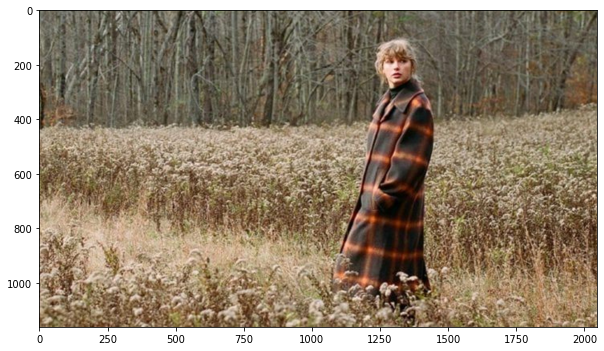

In [ ]:
plt.figure(figsize = (10, 8))
plt.imshow(np.asarray(pic));

In [ ]:
array = np.asarray(pic)

In [ ]:
array.shape

(1162, 2048, 3)

In [ ]:
new_array = array.reshape((-1, 3)).astype(float)

In [ ]:
new_array.shape

(2379776, 3)

# k-means

> build the model

In [ ]:
def Kmeans(data, n_clusters, iterations=10):
    # choose as much as 'n_clusters' random data from points
    centroids = data[np.random.choice(len(data), n_clusters, replace=False), :]
    # the distance of data from centroids
    distances = cdist(data, centroids, 'euclidean')
    # assian each one of data to a centroid (cluster)
    points = np.array([np.argmin(i) for i in distances])
    # step three and four of the algorithm
    for _ in range(iterations): 
        centroids = []
        # STEP THREE
        for cluster in range(n_clusters):
            # updaing centroids
            temp = data[points == cluster].mean(axis=0) 
            # add the new centroid to the list
            centroids += [temp]
        # STEP FOUR
        centroids = np.vstack(centroids)  
        distances = cdist(data, centroids ,'euclidean')
        # updating clustering
        points = np.array([np.argmin(i) for i in distances])
    # returns the clustring and centroids
    return points, centroids

> using on image

In [ ]:
def image_segementation_kmeans(n_clusters, iterations = 10, image = new_array.copy()):
    clusters, centroids = Kmeans(image, n_clusters, iterations)
    new_clusters = (lambda i: centroids[i])(clusters)
    return new_clusters.reshape(array.shape).astype(int)

> compute error on the image

In [ ]:
residual = lambda arr1, arr2 : np.sum((arr1 - arr2) ** 2)

# use on image

In [ ]:
clusters = []

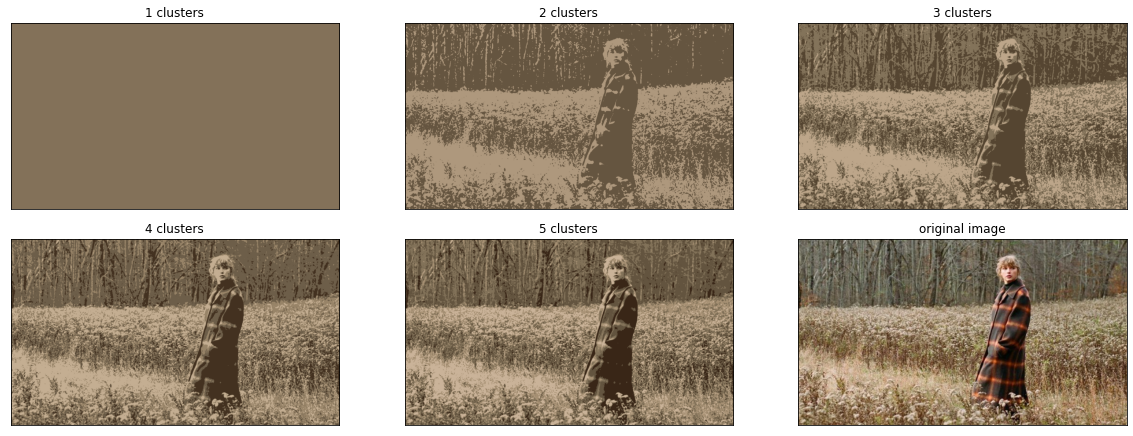

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (20, 15))
plt.subplots_adjust(hspace=0, top = 0.4, bottom = 0)

for i in range(6):
    if i == 5:
        axes[1, 2].imshow(array)
        axes[1, 2].set_title('original image')
        axes[1, 2].xaxis.set_visible(False)
        axes[1, 2].yaxis.set_visible(False) 
    else:
        new_image = image_segementation_kmeans(i + 1)
        clusters.append(new_image)
        axes[i // 3, i % 3].imshow(new_image)
        axes[i // 3, i % 3].set_title(f'{i + 1} clusters')
        axes[i // 3, i % 3].xaxis.set_visible(False)
        axes[i // 3, i % 3].yaxis.set_visible(False) 

and as we see we can take either two or three clsters

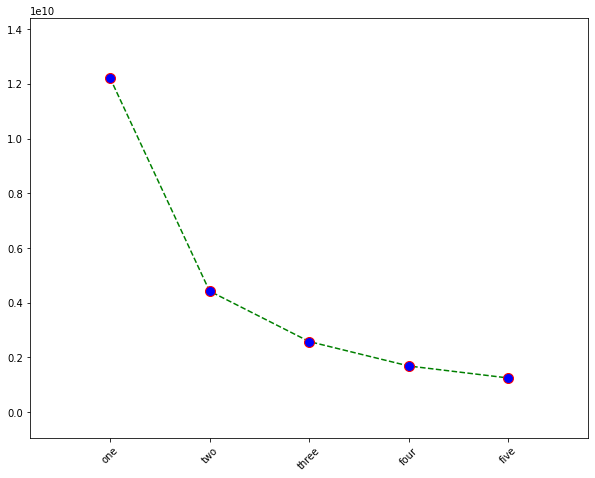

In [ ]:
# setting figure size
plt.figure(figsize = (10, 8))
# computing the errors
error = [residual(array, c) for c in clusters]
# plotting 
plt.plot(list(range(1, 6)), error, marker = 'o', mec = 'r', mfc = 'b', ms = 10, linestyle = 'dashed', color = 'green');
labels = ['one', 'two', 'three', 'four', 'five']
# setting the ticks
plt.xticks(ticks = list(range(1, 6)), labels = labels, rotation = 45)
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom = 0.15)

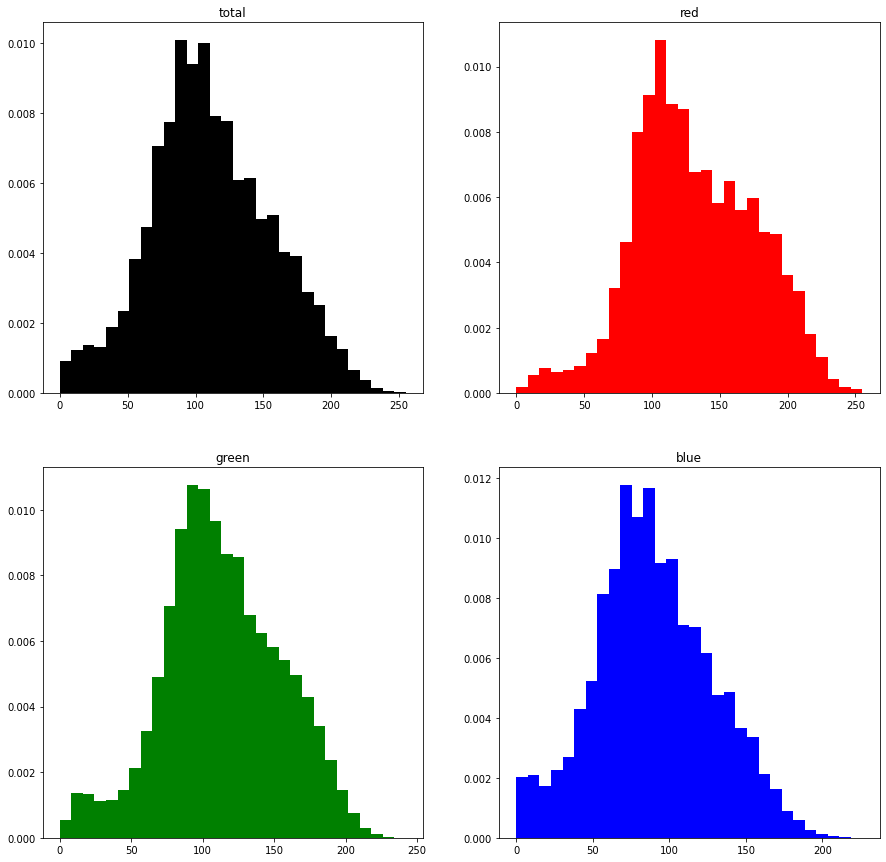

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))

axes[0, 0].hist(new_array.ravel(), bins=30, density=True, color = 'black')
axes[0, 0].set_title('total')
axes[0, 1].hist(new_array[:, 0], bins=30, density=True, color = 'red')
axes[0, 1].set_title('red')
axes[1, 0].hist(new_array[:, 1], bins=30, density=True, color = 'green')
axes[1, 0].set_title('green')
axes[1, 1].hist(new_array[:, 2], bins=30, density=True, color = 'blue')
axes[1, 1].set_title('blue');

# GMM

as we saw with kmeans three is an ideal number of clusters we work with three clusters

In [ ]:
def GMM(data, n_clusters, iteration=10):
    # initialisation step, set phi = (1 / k, 1 / k, ..., 1 / k)
    phi = np.full(1 / n_clusters, shape = (n_clusters))
    # and set initiale weights all equal which means initially we
    # expect every point belongs to all clusters with equal probability
    weights = np.full(1 / n_clusters, shape = data.shape)
    # and then initialise the mu and sigmas
    centroids = data[np.random.choice(len(data), n_clusters, replace=False), :]
    # and set all sigmas initially equal too
    sigma = [np.cov(data.T) for _ in range(n_clusters)]
    # the iteration step (steps three and four)
    for _ in range(iteration):
        ######################### step three #########################
        # update weights and phi holding mu and sigma constant
        weights = probability(data)
        # update phi which is simply mean of rows of weights
        phi = weights.mean(axis=0)
        ########################## step four ##########################
        for i in range(n_clusters):
            weight = weights[:, [i]]
            total_weight = weight.sum()
            centroids[i] = (data * weight).sum(axis=0) / total_weight
            sigma[i] = np.cov(data.T, aweights = (weight / total_weight).ravel(), bias=True)
    return np.argmax(weights, axis=1), centroids

# updating weights
def probability(data, phi, centroids, sigma):
    temp = np.zeros(data.shape[0], len(phi))
    for i in range(len(phi)):
        dist = multivariate_normal(mean = centroids[i], cov = sigma[i])
        temp[:,i] = dist.pdf(data)
    numerator = temp * phi
    denominator = numerator.sum(axis=1)[:, np.newaxis]
    return numerator / denominator

def image_segementation_GMM(n_clusters, iterations = 10, image = new_array.copy()):
    clusters, centroids = Kmeans(image, n_clusters, iterations)
    new_clusters = (lambda i: centroids[i])(clusters)
    return new_clusters.reshape(array.shape).astype(int)

In [ ]:
new_image = image_segementation_GMM(3)

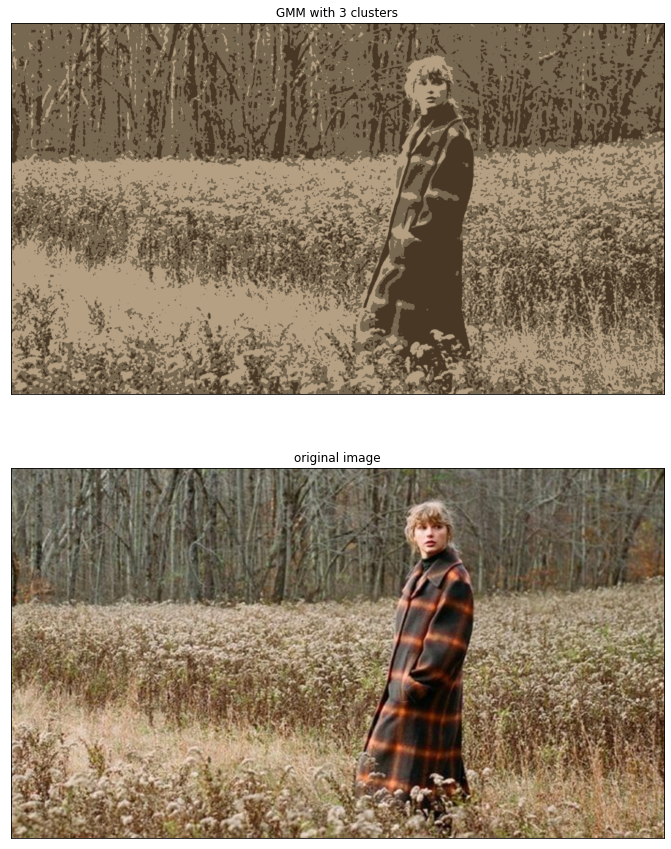

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (15, 15))
axes[0].imshow(new_image)
axes[0].set_title('GMM with 3 clusters')
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False) 
axes[1].imshow(array)
axes[1].set_title('original image')
axes[1].xaxis.set_visible(False)
axes[1].yaxis.set_visible(False);